# Motion detection via 3D convolution

In section 10.4.1, we discussed how to detect motion in a sequence of consecutive images via 3D convolution. This notebook contains the fully functional code for the same.

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
width = 320
height = 320
num_frames = 3

In [3]:
def generate_img(centre_x, centre_y, radius):
    """
    A helper function to help generate our artificial generated image
    """
    img = np.ones([width, height], dtype=np.uint8) * 255
    cv2.circle(img, (centre_x, centre_x), radius, (0, 0, 0), -1)
    return img

def tensor_to_img(x):
    """
    Takes a tensor, does min-max normalization to scale the tensor to a value between 0 and 255
    and returns the resulting numpy array
    """
    x_norm = ((x - x.min()) / (x.max() - x.min())) * 255
    return x_norm.to(torch.uint8).numpy()

For the purpose of demonstration, let us artificially generate a sequence of images that simulates the motion of a ball. 

In [4]:
center_x, center_y = 150, 150
motion_x, motion_y = 30, 30
radius = 40
imgs = []

for i in range(5):
    circle_img = generate_img(center_x + i * motion_x, center_y + i * motion_y, radius)
    imgs.append(circle_img)

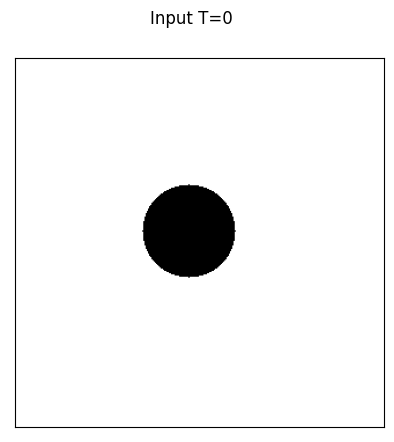

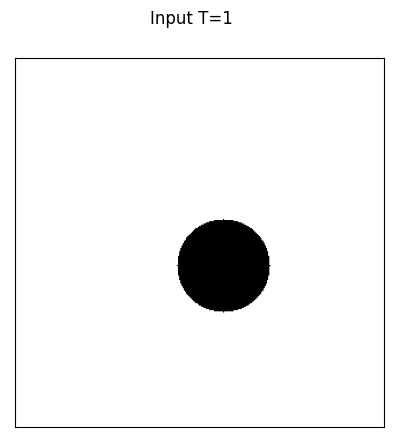

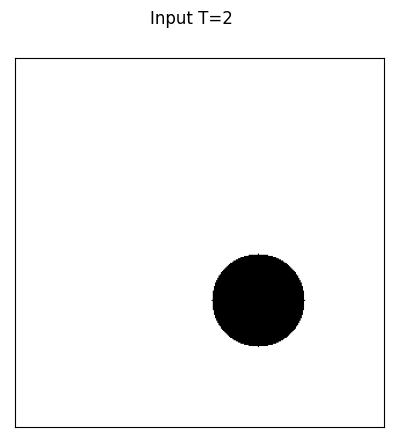

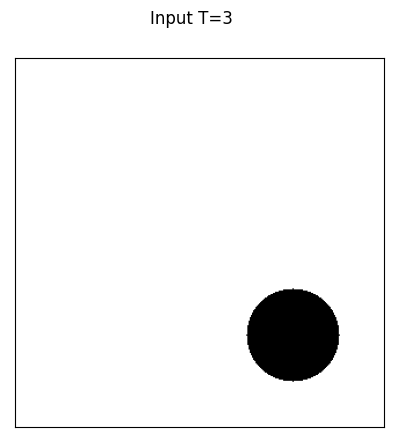

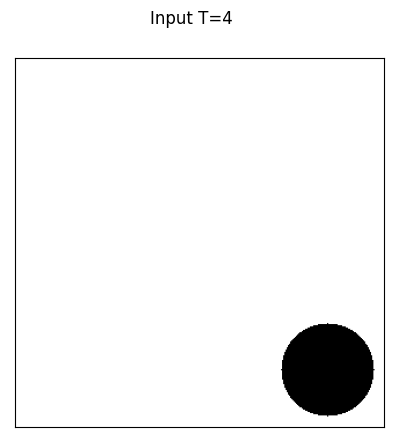

In [5]:
# Let us take a look at the images
for i, img in enumerate(imgs):
    fig = plt.figure() 
    fig.suptitle(f"Input T={i}")
    plt.imshow(img.astype(np.float32) / 255.0, cmap="gray")
    plt.xticks([])
    plt.yticks([])

Let us convert the list of images to a tensor of shape B x C x T x H x W, where B is batch size, C is number of channels, T is number of time steps (a.k.a length of image sequence), H is height and W is width. In our case, B = 1 and C = 1 because we are dealing a single sequence of grayscale images. T = 5 since we are looking at 5 consecutive images. H and W are both 320.

In [6]:
img = torch.tensor([imgs], dtype=torch.float32) # [C, T, H, W] tensor where num channels (C) = 1
img_batch = img.unsqueeze(0) # [B, C, T, H, W] tensor where batch size (B) = 1

/var/folders/tx/pqtg9xkd5156pd7hbgdr_4140000gn/T/ipykernel_82084/2061045849.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  img = torch.tensor([imgs], dtype=torch.float32) # [C, T, H, W] tensor where num channels (C) = 1


Now, let us define the motion detection kernel. It is essentially two 2D smoothing kernels (with inverted weights) stacked along the T dimension, i.e.

$$
\begin{bmatrix}
\begin{bmatrix}
\frac{-1}{9} & \frac{-1}{9} & \frac{-1}{9}\\
\frac{-1}{9} & \frac{-1}{9} & \frac{-1}{9}\\
\frac{-1}{9} & \frac{-1}{9} & \frac{-1}{9}\\
\end{bmatrix}
\begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\
\end{bmatrix}
\end{bmatrix}
$$

When there is motion, we expect pixels in the same spatial location in subsequent frames to have different values. Hence multiplying with the above kernel would result in high values (positive or negative depending on direction of motion) whenever there is motion in the input image.

In [7]:
# Let us define the motion detection kernel
smoothing_2d_kernel = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=torch.float32).unsqueeze(0)
kernel = torch.cat([-smoothing_2d_kernel, smoothing_2d_kernel])
# Conv 2D kernels need to be of shape (out_channel, in_channel, k_t, k_x, k_y). Since we are defining a single kernel
# out_channel = in_channel = 1. So we unsqueeze to add those extra dimensions
kernel = kernel.unsqueeze(0).unsqueeze(0) 
weight = nn.Parameter(data=kernel, requires_grad=False)
print(f"Kernel shape {kernel.shape}\nKernel: {kernel}")  # 1x1x3x3
weight = nn.Parameter(data=kernel, requires_grad=False)

Kernel shape torch.Size([1, 1, 2, 3, 3])
Kernel: tensor([[[[[-1., -1., -1.],
           [-1., -1., -1.],
           [-1., -1., -1.]],

          [[ 1.,  1.,  1.],
           [ 1.,  1.,  1.],
           [ 1.,  1.,  1.]]]]])


In [8]:
# Let us convolve the motion detection kernel over the input image. 
# This can be done in 2 ways. 
# Using conv3d function
out_tensor_1 = F.conv3d(img_batch, weight, padding=0)

# Using conv3d layer
# Conv3D layer
conv3d = nn.Conv3d(1, 1, kernel_size=[2, 3, 3], stride=1, padding=0, bias=False)
conv3d.weight = weight
with torch.no_grad():
    out_tensor_2 = conv3d(img_batch)

In [9]:
assert torch.allclose(out_tensor_1, out_tensor_2)

In the images displayed below, gray represents regions of no motion. Black and white represent regions of motion

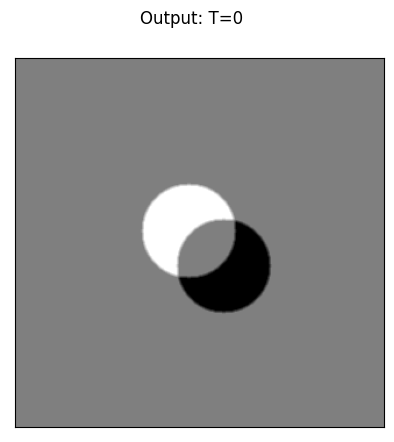

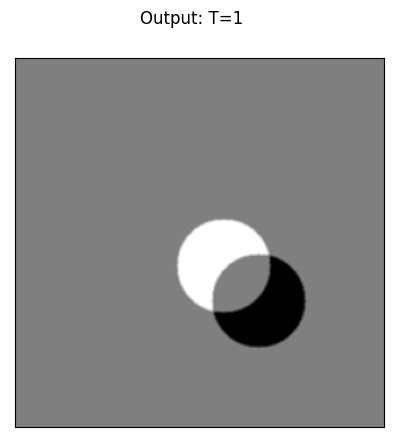

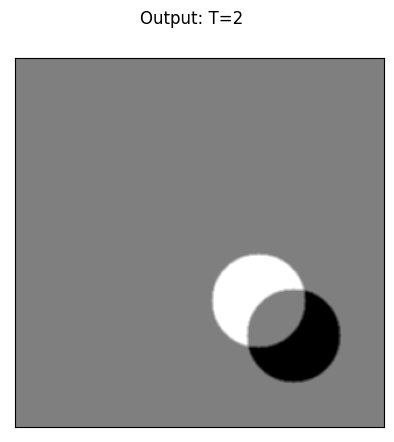

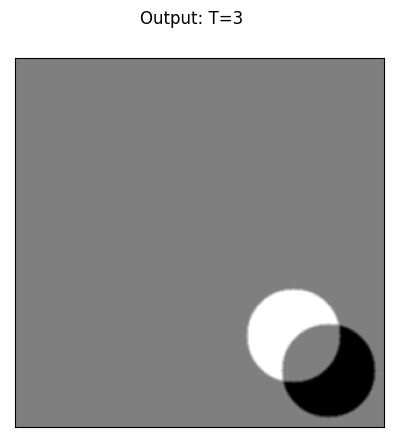

In [10]:
for i, img_tensor in enumerate(out_tensor_1[0][0]):
    img = tensor_to_img(img_tensor)
    fig = plt.figure() 
    fig.suptitle(f"Output: T={i}")
    plt.imshow(img.astype(np.float32) / 255.0, cmap="gray")
    plt.xticks([])
    plt.yticks([])